In [53]:
# Install required packages
# pip install cryptography
# pip install pycryptodomex


In [54]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import matplotlib.pyplot as plt
from cryptography.fernet import Fernet
from Cryptodome.Cipher import AES
import base64

# Objectives
In this notebook, we will be addressing combined optional deliverables Q8

8. Ethics and Privacy Enhancements:
- Develop a comprehensive data anonymization and privacy protection strategy.
- Implement differential privacy techniques for sensitive guest data analysis.
- Create an ethics review process for new features and analyses.

In our survey data collection, we used variables such as age, gender, and occupation to identify the demographic profiles of our respondents. However, managing this type of demographic information often involves handling sensitive data, including personal identifiers and potentially revealing details. Additionally, the TripAdvisor reviews we obtained from the web included sensitive information like the reviewers' locations. These factors highlight significant ethical concerns around privacy and confidentiality. It is crucial to ensure that sensitive data is kept secure and used responsibly to protect respondents' privacy, prevent misuse, and build trust. Hence, in this notebook, we developed a comprehensive data anonymisation strategy to protect the privacy of the individuals. 

## Hypothetical Dataset
First, we create a hypothetical dataset that one may retrieve from the survey respondents

In [55]:
# Initialize Faker
fake = Faker()

# Set random seed for reproducibility
np.random.seed(42)

# Define categorical options for new columns
gender_options = ['Male', 'Female', 'Non-binary']
occupation_options = ['Engineer', 'Teacher', 'Doctor', 'Student', 'Artist', 'Scientist', 'Manager', 'Salesperson']
attractions = ['Roller Coaster', 'Water Slide', 'Theatre Show', 'Meet & Greet', 'Parade']
visit_times = ['Morning', 'Afternoon', 'Evening']

# Function to generate synthetic data
def generate_data(num_rows=200):
    data = {
        'name': [fake.name() for _ in range(num_rows)],
        'age': [random.randint(18, 65) for _ in range(num_rows)],
        'gender': [random.choice(gender_options) for _ in range(num_rows)],
        'occupation': [random.choice(occupation_options) for _ in range(num_rows)],
        'email': [fake.email() for _ in range(num_rows)],
        'location': [fake.country() for _ in range(num_rows)],
        'avg_spend_per_visit': [round(random.uniform(20, 200), 2) for _ in range(num_rows)],
        'time_spent_at_park': [round(random.uniform(2, 10), 1) for _ in range(num_rows)],
        'preferred_attractions': [random.choice(attractions) for _ in range(num_rows)],
        'visit_time_preference': [random.choice(visit_times) for _ in range(num_rows)],
        'published_date': [fake.date_this_decade() for _ in range(num_rows)],
        'park_rating': [random.randint(1, 5) for _ in range(num_rows)]
    }
    
    return pd.DataFrame(data)

# Generate the dataset
df = generate_data()
df.head()

df.to_csv("hypothetical_survey_responses.csv")


## Anonymisation and Privacy Protection
To anonymise the sensitive information in our dataset, we make use of the following strategies:
- Pseudonymisation: Replace identifiable information with pseudonyms or random IDs.
- Generalization: Aggregate or bucket specific values into broader categories (e.g., age groups).
- Masking/Redaction: Mask sensitive parts of data (like emails).
- Feature Selection: Features that contain sensitive information not useful for analysis can be dropped. 

In [56]:
# Step 1: Pseudonymise names by replacing them with unique guest IDs
df['guest_id'] = ['guest_' + str(i).zfill(3) for i in range(1, df.shape[0] + 1)]

# Step 2: Generalize age into age groups
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Step 3: Mask part of the email addresses
df['masked_email'] = df['email'].apply(lambda x: x.split('@')[0][:2] + '***@' + x.split('@')[1])

# Step 4: Drop senstive features not useful for analysis
df = df.drop(columns=['occupation'])

# Display the anonymized dataset
df[['guest_id', 'age_group', 'masked_email', 'gender', 'location', 'avg_spend_per_visit',
    'time_spent_at_park', 'preferred_attractions', 'visit_time_preference', 'published_date', 'park_rating']]


,guest_id,age_group,masked_email,gender,location,avg_spend_per_visit,time_spent_at_park,preferred_attractions,visit_time_preference,published_date,park_rating
0,guest_001,45-54,ca***@example.org,Male,Vanuatu,92.08,6.0,Water Slide,Evening,2023-04-07,3
1,guest_002,55-64,st***@example.org,Male,Suriname,102.23,6.4,Theatre Show,Morning,2023-12-06,5
2,guest_003,25-34,ch***@example.net,Female,Heard Island and McDonald Islands,69.17,8.6,Roller Coaster,Morning,2021-08-14,4
3,guest_004,18-24,sc***@example.net,Male,Samoa,40.67,3.8,Water Slide,Morning,2021-07-12,4
4,guest_005,35-44,dn***@example.org,Non-binary,Marshall Islands,194.10,7.6,Meet & Greet,Afternoon,2022-07-02,4
...,...,...,...,...,...,...,...,...,...,...,...
195,guest_196,55-64,an***@example.com,Female,Suriname,138.55,3.5,Meet & Greet,Evening,2024-09-19,3
196,guest_197,55-64,et***@example.com,Female,Guam,70.47,6.5,Theatre Show,Afternoon,2022-02-01,1
197,guest_198,55-64,jo***@example.net,Non-binary,Pitcairn Islands,89.97,8.9,Roller Coaster,Morning,2021-09-17,2
198,guest_199,55-64,ps***@example.com,Female,Costa Rica,78.44,9.4,Parade,Afternoon,2024-10-25,2


## Differential Privacy 
Differential privacy is a mathematical framework that ensures statistical analyses do not reveal information about any single individual in the dataset. It introduces controlled noise into the data or results to protect individual privacy while preserving the overall patterns.

We explore two main strategies:
1. Laplace Noise Addition: Adding noise drawn from a Laplace distribution to numerical data on sensitive guest information, to ensure the data doesn't expose specific values when aggregated.
2. Differentially Private Query Mechanisms: Applying noise to query results rather than modifying the original dataset. For example, adding noise to aggregates (e.g., average, sum, count) for a more general output while preserving privacy.


### 1. Laplace Noise Addition (for numerical data)
Laplace noise is added based on the sensitivity of the data and a chosen epsilon (ε) parameter, which controls the trade-off between privacy and accuracy. The larger the ε, the less noise is added, and the more accurate the data. However, larger noise adds more privacy protection. This typically ranges from 0.001 to 10 in practical applications. 

The formula for generating Laplace noise is:

$$\text{Noise} = \text{Laplace}(0, \frac{\Delta f}{\epsilon})$$

Where:
- $\Delta f$ is the **sensitivity** of the function, which represents the maximum possible change in the output due to a single record change.
- $\epsilon$ is the **privacy budget**, which controls the trade-off between privacy and accuracy. A smaller $\epsilon$ value adds more noise and provides more privacy. 
- The **Laplace distribution** has a mean of 0 and a scale parameter of $$\frac{\Delta f}{\epsilon}$$ where the scale parameter controls the spread of the noise.




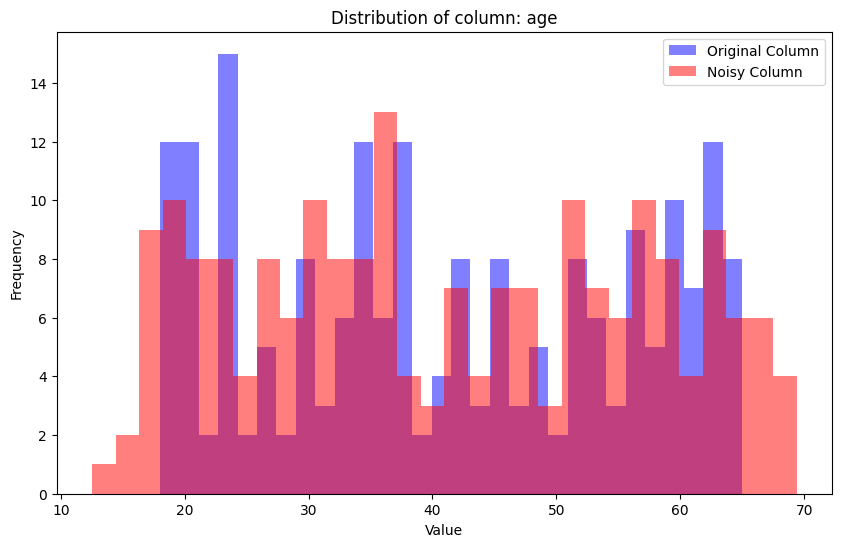

In [57]:
# Function to add Laplace noise to a column
def add_laplace_noise(df, column, epsilon=1.0, min_value=0.01):

    # Compute the IQR (Interquartile Range) of the column to be used as sensitivity
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range
    
    # Laplace noise scale = IQR / epsilon, multiplied by a factor of 0.1 to reduce the impact
    scale = 0.1 * (IQR / epsilon)
    
    # Adding Laplace noise
    noise = np.random.laplace(0, scale, size=len(df))
    
    # Adding noise to the original column
    noisy_column = df[column] + noise

    # Ensure that noisy values are greater than the specified min_value
    noisy_column = np.maximum(noisy_column, min_value)

    # Add the noisy column to the dataframe
    df[column + '_noisy'] = noisy_column


    # Plot the original vs noisy distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, alpha=0.5, label='Original Column', color='blue')
    plt.hist(df[column + '_noisy'], bins=30, alpha=0.5, label='Noisy Column', color='red')
    plt.title(f'Distribution of column: {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()
    
    return df

# Apply Laplace noise to the 'age' column
df = add_laplace_noise(df, 'age')

As can be seen from the plots above, the Laplace noise addition ensures that the range of the data remains similar to that of the original column, allowing for further data analysis to determine trends without revealing the sensitive information of the individual. The amount of noise added is controlled by the privacy budget (represented by epsilon, ϵ), allowing users to fine-tune the balance between privacy protection and accuracy. Furthermore, it is simple to implement and computationally efficient, making it an effective method for privacy enhancement strategies.


### 2. Differentially Private Query Mechanism (for aggregating data)
Instead of modifying the dataset directly, we can also apply noise when querying the data. For example, we could calculate a noisy mean or noisy count by adding Laplace noise to the result.

In [58]:
# Function to add noise to a query 
def noisy_average(df, column, epsilon=1.0):

    # Compute the IQR (Interquartile Range) of the column to be used as sensitivity
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range
    
    # Laplace noise scale = IQR / epsilon, multiplied by a factor of 0.1 to reduce the impact
    scale = 0.1 * (IQR / epsilon)
    
    # Actual mean of the column
    true_mean = df[column].mean()
    
    # Add Laplace noise to the mean
    noisy_mean = true_mean + np.random.laplace(0, scale)

    # Initial mean of column
    initial_mean = df[column].mean()
    
    return noisy_mean, initial_mean

# Calculate noisy average for 'age'
noisy_age, initial_age = noisy_average(df, 'age')

# Output the noisy average
print(f"Noisy average age of reviewer: {noisy_age}, Initial average age of reviewer: {initial_age}")


Noisy average age of reviewer: 42.15559557294614, Initial average age of reviewe: 41.245


This example shows how this technique can ensure individual privacy in the results of aggregated queries. Those who are not immediately in contact with the sensitive data cannot infer the data of a specific individual by examining the aggregated result, even if they have access to all other data points. This may be trivial for age data, but can have many implications for more sensitive data such as incomes. 

## Data Encryption
Encryption ensures that data remains secure while it is stored or transmitted. Even if the data is intercepted, it cannot be read without the decryption key.

We explore two main strategies:
1. Field-Level Encryption:
Since the hypothetical dataset contains sensitive information (such as email, location, and ratings), this is an effective technique used to protect only the sensitive fields without the need for encrypting the entire dataset.
2. Symmetric Encryption (AES): A more secure and scalable way that allows secure handling of datasets. Since it is symmetric, data can be easily encrypted and decrypted with the same key, making it suitable for use cases that require the reading and processing of encrypted data.


### 1. Field-Level Encryption

By using field-level encryption, we can select which fields in a dataset should be encrypted, allowing us to limit the exposure of sensitive data to only those who need access to it. This can be seen in the example below, where we choose to encrypt fields such as `email` and `location`, to protect the privacy of our survey repondents. 

In [59]:
# Generating a key and creating a Fernet cipher object
key = Fernet.generate_key()
cipher = Fernet(key)

# Encrypting the email and location column
df['encrypted_email'] = df['email'].apply(lambda x: cipher.encrypt(x.encode()).decode())
df['encrypted_location'] = df['location'].apply(lambda x: cipher.encrypt(x.encode()).decode())

df[['guest_id', 'email', 'encrypted_email', 'location', 'encrypted_location']]


,guest_id,email,encrypted_email,location,encrypted_location
0,guest_001,catherinepatrick@example.org,gAAAAABnMxUFEptWAkXkgLnLx7Lx5eSTcH-u4YPrjxSbjt...,Vanuatu,gAAAAABnMxUFnFfCpxAhfmGErhUpocvmOU3sW0rWk6LNCC...
1,guest_002,stewartjerry@example.org,gAAAAABnMxUFBd94sOiI8qzJCU-uBhDaFGhQ3noRphxv1N...,Suriname,gAAAAABnMxUF-Q5yaCtZN949GLzuo3sEuJ78Pl-zCRfGuh...
2,guest_003,christopher31@example.net,gAAAAABnMxUFtedEZfhsexiMszC8BXAkuH3eR9hWGhz5OZ...,Heard Island and McDonald Islands,gAAAAABnMxUFMsvHHO6BeeMzUrfws3MD52KrrHoJnNnCqO...
3,guest_004,scottwilliams@example.net,gAAAAABnMxUF2ImaVUf164nCUKg_vY5OvQqX98ECGE-GRM...,Samoa,gAAAAABnMxUFFqQlYECGEdg0IOpkNl-p_kXt6JUaIQ7e4C...
4,guest_005,dnguyen@example.org,gAAAAABnMxUFccISLM66sorTM70bmlZXCukbsK5JZgJPlT...,Marshall Islands,gAAAAABnMxUF51cdiNmEO46Rn8roOh_R3z8E22psF9oCYM...
...,...,...,...,...,...
195,guest_196,ann68@example.com,gAAAAABnMxUFx9TvzjwU2Z8JTU6LVpGhh954V-Gj6ygf1L...,Suriname,gAAAAABnMxUFLky2RS6FRsfT82yFaaPaL5CcxBbpolXXDq...
196,guest_197,etaylor@example.com,gAAAAABnMxUF70wuqsKkF8mypna89MM4ie1kYDTrCfMuZo...,Guam,gAAAAABnMxUFskTkHjPYkeMGMGXZTKA_8ITFDmhejyDD22...
197,guest_198,john52@example.net,gAAAAABnMxUFiufP7DNXIy1K6G9ur-SrhmidMDhjCyUkRZ...,Pitcairn Islands,gAAAAABnMxUFHC2TtsN4UiJQZtV4b9vrJjR-L4BXa55Jkw...
198,guest_199,pstone@example.com,gAAAAABnMxUFvAcSv95ma3uSzWW9Qgp5MQZW9QTu2EpOix...,Costa Rica,gAAAAABnMxUFSeziUcqqhr0dhEh-xzDrxlwF8e5evGmF4H...


### 2. Symmetric Encryption (AES)

This encryption strategy makes use of the same key for both encrypting and decrypting data. The selected rows of data are encrypted using a secret key and transformed into ciphertext, preventing others from deciphering the data stored in the columns. 

In the below example, we demonstrate how encryption and decryption is used for the column `age`. The generated key and iv would have to be shared securely between parties. 

Of course, encrypting columns of age may be trivial, but this would be necessary for columns storing income information, for instance. 

In [60]:
# Function to pad data to be 16-byte aligned (for AES)
def pad(data):
    while len(data) % 16 != 0:
        data += ' '
    return data

# Generating a secret key and IV for AES encryption (must be 16, 24, or 32 bytes long)
key = b'Sixteen byte key'  # Key shared securely between parties
iv = b'1234567890123456'   # 16-byte IV (also needs to be shared securely)


# Encryption function
def encrypt(value, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, iv=iv)
    padded_value = pad(str(value))
    encrypted_bytes = cipher.encrypt(padded_value.encode())
    return base64.b64encode(encrypted_bytes).decode()

# Encrypting the 'age' column
df['encrypted_age'] = df['age'].apply(lambda x: encrypt(x, key, iv))

df[['guest_id', 'age', 'encrypted_age']]


,guest_id,age,encrypted_age
0,guest_001,52,+OpiGMEgWHpc0zqc7eFvYA==
1,guest_002,61,5s8Wea7P1vA3qF2BrXRTMg==
2,guest_003,25,sUUZc2izdkoFFsXuiBNYNQ==
3,guest_004,20,skNSux09GjDvCu9Rqu7IXw==
4,guest_005,35,AYRLEdyoVXR52Vp9RRMFoA==
...,...,...,...
195,guest_196,59,gQULkh6Bq9PODbjA/fkK0A==
196,guest_197,61,5s8Wea7P1vA3qF2BrXRTMg==
197,guest_198,60,Ua2qG30d5tfQpWUOb/f11A==
198,guest_199,64,/soKO10LyDRjcNR36RzCLQ==


The below code simulates the decryption of the column `age` by another individual, who has access to the key and iv

In [62]:
# Function to unpad the data after decryption
def unpad(data):
    return data.rstrip(' ')

# Decryption function
def decrypt(encrypted_value, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, iv=iv)
    decoded_bytes = base64.b64decode(encrypted_value)
    decrypted_bytes = cipher.decrypt(decoded_bytes)
    return unpad(decrypted_bytes.decode())

# Simulating the other party decrypting the data
df['decrypted_age'] = df['encrypted_age'].apply(lambda x: decrypt(x, key, iv))

# Display the dataframe with original, encrypted, and decrypted values
df[['guest_id', 'age', 'encrypted_age', 'decrypted_age']]


,guest_id,age,encrypted_age,decrypted_age
0,guest_001,52,+OpiGMEgWHpc0zqc7eFvYA==,52
1,guest_002,61,5s8Wea7P1vA3qF2BrXRTMg==,61
2,guest_003,25,sUUZc2izdkoFFsXuiBNYNQ==,25
3,guest_004,20,skNSux09GjDvCu9Rqu7IXw==,20
4,guest_005,35,AYRLEdyoVXR52Vp9RRMFoA==,35
...,...,...,...,...
195,guest_196,59,gQULkh6Bq9PODbjA/fkK0A==,59
196,guest_197,61,5s8Wea7P1vA3qF2BrXRTMg==,61
197,guest_198,60,Ua2qG30d5tfQpWUOb/f11A==,60
198,guest_199,64,/soKO10LyDRjcNR36RzCLQ==,64


## Ethics review process for new features and analyses

### 1. **Preliminary Assessment**
- Determine the purpose of each new feature or analysis.
- Justify the use of the feature or analysis in targeting a specific problem or business objective. 
- List the data required for such a feature, and whether it is necessary for this feature to be implemented. 
- Ensure that the intended use of the data benefits customers and stakeholders without infringing on privacy.

### 2. **Data Collection & Anonymization Strategy**
- Collect only necessary data for the analysis
- Pseudonymisation: Replace personal identifiers (e.g. names, profiles) with pseudonyms to protect individual identities.
- Masking/Reaction: Mask sensitive parts of data (e.g. income, emails)
- Assess if the anonymisation strategies used effectively prevents re-identification of individuals.

### 3. **Implementation of Differential Privacy**
- Ensure that the results of data analysis do not reveal sensitive information about any individual.
- **Steps**:
    - Apply **Laplace noise** to numerical data (e.g ratings, spending, time spent).
    - Use **Differentially Private Query Mechanisms** for aggregating data (e.g calculating average park satisfaction scores) to add noise to aggregated results rather than the raw data.
- **Assessment**:
    - Confirm that an appropriate **epsilon (ε)** value is used to balance privacy with accuracy. 

### 4. **Data Security & Field-Level Encryption**
- Use appropriate encryption strategies to protect the privacy of individuals. 
- **Encryption Strategy**:
    - **Symmetric Encryption (AES)**: Encrypt sensitive fields (e.g., park ratings, visitor feedback) to secure data both at rest and in transit.
    - **Key Management**: Ensure that encryption keys are securely stored and accessible only to authorized personnel.
- **Assessment**:
    - Confirm that encryption is applied consistently across all sensitive data fields.
    - Review access control policies to limit data access to only those who need it.

### 5. **Ethical Impact Analysis**
- Identify potential risks, such as data breaches, re-identification of individuals, or misuse of data.
- Develop strategies to mitigate identified risks, such as improved anonymisation techniques. 

### 6. **Informed Consent & Transparency**
- Ensure that users are informed about data collection and provide their consent for their survey responses to be used for other analyses. 
- Communicate to users how their data will be protected to safeguard their privacy

### 7. **Review & Ongoing Monitoring**
- Obtain approval from an ethics committee before implementation of a new feature or analysis
- Regularly review and audit data handling processes to ensure compliance to the regulations
- Revise privacy measures and ethical guidelines to adapt to changing regulations
- Ensure that detailed documentation is always maintained

With this 7 step strategy to review new features and analysis, this will ensure that any new feature to be deployed matches the ethical guidelines and protects the privacy of all individuals. 